**Лабоаторная работа № 2**

Выполнил студент группы ББМО-02-23

**Курченко Иван Дмитриевич**

1. ## Установка библиотеки *adversarial-robustness-toolbox*
Библиотека Adversarial Robustness Toolbox (ART) предназначена для анализа, разработки и защиты моделей машинного обучения от атак злоумышленников.

In [1]:
!pip install adversarial-robustness-toolbox

2. ## Импорт библиотек

In [2]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

3. ## Загрузка датасета с Kaggle с помощью KaggleHub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


4. ## Задание путей к разархивированным данным

 **Задание путей к разархивированным данным**  
   В этом разделе задаются пути к разархивированным данным датасета **GTSRB** (German Traffic Sign Recognition Benchmark).  
   - **`data_path`**: основной путь к разархивированным данным.  
   - **`train_dir`**: путь к тренировочной выборке, которая хранится в папке `Train`.  
   - **`val_dir`**: путь к тестовой выборке, которая хранится в папке `Test`.  
   - **`meta_dir`**: путь к метаданным датасета, хранящимся в папке `Meta`.

 **Просмотр содержимого папки с тренировочными данными**  
   В этом шаге используется команда **`%ls`** для вывода списка файлов в папке `Train`, содержащей изображения, используемые для обучения модели. Это позволяет убедиться в наличии необходимых файлов и их структуре.

In [4]:
# задаем пути к разархивированным данным
data_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
train_dir = os.path.join(data_path, 'Train')
val_dir = os.path.join(data_path, 'Test')
meta_dir = os.path.join(data_path, 'Meta')
%ls /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train

0/   11/  14/  17/  2/   22/  25/  28/  30/  33/  36/  39/  41/  6/  9/
1/   12/  15/  18/  20/  23/  26/  29/  31/  34/  37/  4/   42/  7/
10/  13/  16/  19/  21/  24/  27/  3/   32/  35/  38/  40/  5/   8/


5. ## Разделение данных на тренировочный и тестовый наборы


1. **Задание путей к исходным и целевым папкам**  
   В этом шаге задаются пути к исходной папке с данными и папке для хранения разделённых данных:
   - **`source_dir`**: путь к исходным данным, хранящимся в папке с тренировочными изображениями.
   - **`output_dir`**: путь, где будут сохраняться обработанные данные (тренировочные и тестовые).

2. **Создание папок для разделённых данных**  
   Создаются две основные папки для хранения:
   - **`train_dir`**: папка для тренировочных данных.
   - **`test_dir`**: папка для тестовых данных.

3. **Разделение данных на тренировочные и тестовые наборы**  
   В этом шаге данные каждого класса разбиваются на две группы (тренировочную и тестовую) с использованием функции **`train_test_split`**:
   - **`test_size`**: доля данных, которая будет использоваться для тестовой выборки (20% в данном примере).
   - Для каждого класса создаются отдельные папки и файлы копируются в них.

4. **Копирование файлов в соответствующие папки**  
   После разделения данные копируются в соответствующие папки тренировочного и тестового наборов.

5. **Вывод результата**  
   Выводится сообщение об успешном разделении данных, указывая путь к сохранённым тренировочным и тестовым данным.

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Путь к исходной папке с данными
source_dir = train_dir  # Папка с исходными данными, разбитыми по классам
output_dir = os.path.join(data_path, 'ProcessedData')  # Папка для хранения разделенных данных

# Создаем папки для тренировочных и тестовых данных
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Разделение данных
test_size = 0.2  # Доля данных для тестового набора

# Проходим по каждому классу
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    # Проверяем, что это директория
    if os.path.isdir(class_path):
        # Создаем соответствующие папки для класса в train и test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Получаем список всех файлов в классе
        files = os.listdir(class_path)
        files = [f for f in files if os.path.isfile(os.path.join(class_path, f))]

        # Разделяем файлы на тренировочные и тестовые
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Копируем файлы в соответствующие папки
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print(f"Данные успешно разделены. Тренировочные данные: {train_dir}, Тестовые данные: {test_dir}")


Данные успешно разделены. Тренировочные данные: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/ProcessedData/train, Тестовые данные: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/ProcessedData/test


6. ## Обучение модели на основе ResNet50 с применением аугментации данных


1. **Предобработка и аугментация данных**  
   В данном шаге создается объект `ImageDataGenerator` для аугментации данных. Аугментация включает в себя:
   - Нормализацию изображений (масштабирование значений пикселей от 0 до 1).
   - Применение различных преобразований (повороты, сдвиги, изменение масштаба и пр.), чтобы увеличить разнообразие тренировочных данных и повысить общую устойчивость модели.
   - Разделение данных на тренировочную и валидационную выборки с использованием `validation_split=0.2`.

2. **Загрузка предобученной модели ResNet50**  
   Используется предобученная модель **ResNet50** с весами, полученными на наборе данных **ImageNet**. В модели отключен верхний слой, так как мы будем добавлять свои слои для классификации 43 классов дорожных знаков.

3. **Добавление пользовательских слоев**  
   К предобученной модели добавляются несколько пользовательских слоев:
   - **GlobalAveragePooling2D** для уменьшения размерности.
   - Плотный слой с 256 нейронами и функцией активации **ReLU**.
   - Выходной слой с количеством нейронов, равным количеству классов (43), с функцией активации **softmax** для многоклассовой классификации.

4. **"Заморозка" базовой модели**  
   На начальном этапе обучения веса базовой модели **ResNet50** фиксируются, чтобы они не изменялись в ходе обучения. Это помогает избежать изменения предобученных параметров во время первой фазы тренировки.

5. **Компиляция модели**  
   Модель компилируется с использованием оптимизатора **Adam** и функции потерь **categorical_crossentropy** для многоклассовой классификации. Используется метрика **accuracy** для отслеживания качества модели.

6. **Обучение модели**  
   Модель обучается на тренировочных данных в течение 10 эпох. В качестве валидации используются данные из `val_generator`, созданного на основе тестовой выборки.

7. **Разморозка и дообучение**  
   После начальной фазы обучения все слои модели размораживаются, чтобы дообучить модель и позволить корректировать веса базовой модели. Параметры модели снова компилируются с малым коэффициентом обучения (**learning rate = 1e-5**) для предотвращения значительных изменений в весах. Модель обучается ещё 10 эпох для финальной донастройки.

8. **Сохранение модели**  
   После завершения обучения модель сохраняется в файл **'ResNet50.h5'**, чтобы можно было использовать ее для предсказаний на новых данных.

In [6]:
IMG_SIZE = (224, 224)  # ResNet50 ожидает 224x224 изображения
BATCH_SIZE = 32
NUM_CLASSES = 43  # GTSRB содержит 43 класса
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. Загрузка предобученной ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. Добавление пользовательских слоев
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Дополнительный плотный слой
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. "Заморозка" базовой модели для предотвращения изменения весов во время начального обучения
for layer in base_model.layers:
    layer.trainable = False

# 5. Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Обучение модели
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 7. Разморозка и дообучение
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)
save_model(model, 'ResNet50.h5')

Found 25110 images belonging to 43 classes.
Found 1550 images belonging to 43 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/785 ━━━━━━━━━━━━━━━━━━━━ 347s 424ms/step - accuracy: 0.0735 - loss: 3.4637 - val_accuracy: 0.1226 - val_loss: 3.2337
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 360s 402ms/step - accuracy: 0.1345 - loss: 3.2221 - val_accuracy: 0.1652 - val_loss: 3.0790
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 321s 401ms/step - accuracy: 0.1755 - loss: 3.0405 - val_accuracy: 0.1574 - val_loss: 3.0045
Epoch 4/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 314s 397ms/step - accuracy: 0.1948 - loss: 2.9227 - val_accuracy: 0.1787 - val_loss: 2.9437
Epoch 5/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 322s 398ms/step - accuracy: 0.2170 - loss: 2.8378 - val_accuracy: 0.2006 - val_loss: 2.8565
Epoch 6/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 310s 392ms/step - accuracy: 0.2292 - loss: 2.7606 - val_accuracy: 0.2368 - val_loss: 2.7919
Epoch 7/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 329s 399ms/step - accuracy: 0.2477 - loss: 2.6851 - val_accuracy: 0.2374 - val_loss: 2.7680
Epoch 8/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 313s 397ms/step - accuracy: 0.2554 - loss: 2.63

7. ## Обучение модели на основе VGG16 с аугментацией данных


1. **Предобработка и аугментация данных**  
   В этом шаге создается объект `ImageDataGenerator` для аугментации данных с различными параметрами:
   - Масштабирование изображений.
   - Повороты, сдвиги по осям, сдвиг масштаба, искажения, зум и другие аугментации для улучшения обобщающей способности модели.
   - Разделение данных на тренировочную и валидационную выборки с помощью параметра `validation_split=0.2`.

2. **Загрузка предобученной модели VGG16**  
   Используется предобученная модель **VGG16**, которая уже обучена на наборе данных **ImageNet**, с отключенным верхним слоем для использования в качестве базовой модели.

3. **Добавление пользовательских слоев**  
   В качестве классификатора добавляются дополнительные слои:
   - **Flatten** для выравнивания выходных данных.
   - Два плотных слоя с 256 нейронами и активацией **ReLU**.
   - Слои **Dropout** для регуляризации.
   - Выходной слой с функцией активации **softmax**, размерность которого равна количеству классов (43) для классификации дорожных знаков GTSRB.

4. **"Заморозка" базовых слоев**  
   На начальном этапе все слои предобученной модели замораживаются, чтобы избежать изменения весов во время первой фазы обучения.

5. **Компиляция модели**  
   Модель компилируется с оптимизатором **Adam** и функцией потерь **categorical_crossentropy** для многоклассовой классификации, а также метрикой **accuracy**.

6. **Обучение модели**  
   Модель обучается с использованием `train2_generator` для тренировки и `val2_generator` для валидации. Обучение проводится в течение 5 эпох.

7. **Разморозка и дообучение**  
   После начальной фазы обучения замороженные слои размораживаются, чтобы провести дообучение модели с очень маленьким шагом (learning rate = 1e-5). Модель дообучается ещё 5 эпох.

8. **Сохранение модели**  
   Модель сохраняется в файл **'vgg16.h5'**, что позволяет использовать её для дальнейших предсказаний или анализа.

In [7]:
# Создание генераторов данных с аугментацией
train2_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train2_generator = train2_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val2_generator = train2_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. Загрузка предобученной модели VGG16
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. Добавление пользовательских слоев
x = base_model2.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Первый плотный слой
x = Dropout(0.5)(x)  # Dropout для регуляризации
x = Dense(256, activation='relu')(x)  # Второй плотный слой
x = Dropout(0.5)(x)  # Dropout для регуляризации
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Выходной слой с количеством классов GTSRB

model2 = Model(inputs=base_model2.input, outputs=predictions)

# 4. Заморозка базовых слоев
for layer in base_model.layers:
    layer.trainable = False

# 5. Компиляция модели
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Обучение модели
history = model2.fit(
    train2_generator,
    epochs=5,
    validation_data=val2_generator
)

# 7. Разморозка и дообучение
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train2_generator,
    epochs=5,
    validation_data=val2_generator
)

# 8. Сохранение модели
model.save('vgg16.h5')

Found 25110 images belonging to 43 classes.
Found 1550 images belonging to 43 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 539s 631ms/step - accuracy: 0.0487 - loss: 3.6454 - val_accuracy: 0.0581 - val_loss: 3.4836
Epoch 2/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 458s 547ms/step - accuracy: 0.0533 - loss: 3.4960 - val_accuracy: 0.0542 - val_loss: 3.4811
Epoch 3/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 426s 540ms/step - accuracy: 0.0563 - loss: 3.4944 - val_accuracy: 0.0568 - val_loss: 3.4803
Epoch 4/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 428s 543ms/step - accuracy: 0.0579 - loss: 3.4972 - val_accuracy: 0.0529 - val_loss: 3.4790
Epoch 5/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 427s 540ms/step - accuracy: 0.0539 - loss: 3.4922 - val_accuracy: 0.0568 - val_loss: 3.4785
Epoch 1/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 446s 502ms/step - accuracy: 0.9948 - loss: 0.0185 - val_accuracy: 0.9594 - val_loss: 0.1309
Epoch 2/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 375s 475ms/step - accuracy: 0.9965 - 

8. ## Визуализация обучения модели VGG16: точность и потери

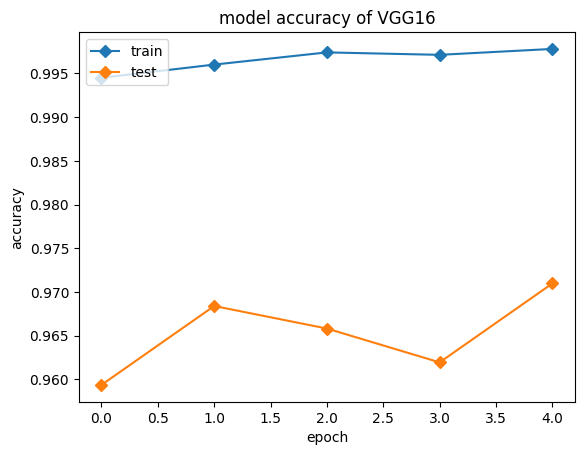

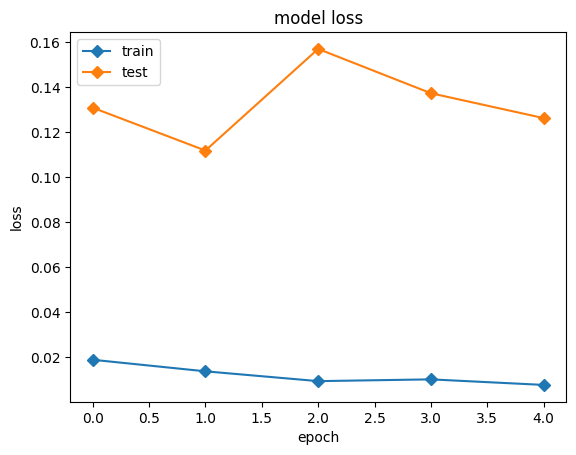

In [8]:
plt.plot(history_fine_tune.history['accuracy'], marker='D')
plt.plot(history_fine_tune.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history_fine_tune.history['loss'], marker='D')
plt.plot(history_fine_tune.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

9. ## Подключение Google Drive для работы с файлами

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


10. ## Реализация атаки FGSM для оценки устойчивости модели ResNet50


1. **Загрузка предобученной модели**  
   Загружается модель `ResNet50` из файла `ResNet50.h5`, который был ранее сохранен. Эта модель будет использоваться для дальнейшей оценки устойчивости к атакам. Включается **eager execution** в TensorFlow для динамического вычисления значений.

2. **Подготовка тестовых данных**  
   - Создается генератор `test_generator` для загрузки и предварительной обработки тестовых изображений с помощью `ImageDataGenerator`. Эти данные будут использоваться как база для атак.
   - Используется масштабирование значений пикселей (rescale) для преобразования в диапазон от 0 до 1.

3. **Инициализация модели для атаки**  
   Для атаки используется библиотека `art` (Adversarial Robustness Toolbox) и класс `TensorFlowV2Classifier`, который интегрирует модель `ResNet50` и обеспечивает расчет атак. Определяется функция потерь для многоклассовой классификации и передается модель в классификатор.

4. **Настройка атаки FGSM (Fast Gradient Sign Method)**  
   Атака FGSM применяется с различными значениями параметра `eps` (переменная, определяющая степень искажения изображений). Атака создает искаженные изображения, используя маленькие изменения в пикселях, чтобы сбить с толку модель.

5. **Оценка точности модели на атакованных данных**  
   Для каждого значения `eps` генерируются атакованные изображения, и производится предсказание модели на этих искаженных данных. Затем оценивается точность предсказаний на атакованных данных, и результаты сохраняются.

6. **Вывод результатов**  
   После выполнения атак на каждом значении `eps`, результаты точности на атакованных данных выводятся, чтобы проанализировать, как различные уровни искажений влияют на производительность модели.

In [12]:
from art.estimators.classification import TensorFlowV2Classifier
model_attack = tf.keras.models.load_model('/content/ResNet50.h5')
tf.compat.v1.enable_eager_execution()
print("Eager Execution:", tf.executing_eagerly())
IMG_SIZE = (224, 224)
test_dir = os.path.join(output_dir, 'test')

# Создаем генератор тестовых данных
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=50,  # Загрузим все данные для атаки
    class_mode='categorical',
    shuffle=False
)

# Извлекаем данные и метки
x_test, y_test = next(test_generator)
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

def predict_fn(x, training=False):
    return model_attack(x, training=False)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # Функция потерь

classifier = TensorFlowV2Classifier(
    model=predict_fn,
    nb_classes=43,  # Количество классов GTSRB
    input_shape=(224, 224, 3),
    clip_values=(0, 1),
    loss_object=loss_object  # Передача функции потерь
)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

results = []
for eps in eps_range:
    print(f"Выполняется атака FGSM с eps={eps:.6f}...")

    # Создание FGSM атаки с текущим eps
    attack = FastGradientMethod(estimator=classifier, eps=eps)

    # Генерация атакованных данных
    x_test_adv = attack.generate(x=x_test)

    # Оценка модели на атакованных данных
    predictions = classifier.predict(x_test_adv, batch_size=50)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"Точность на атакованных данных (eps={eps:.6f}): {accuracy * 100:.2f}%")

    # Сохраняем результаты
    results.append({'eps': eps, 'accuracy': accuracy})

print("\nРезультаты атак:")
for result in results:
    print(f"eps={result['eps']:.6f}, accuracy={result['accuracy'] * 100:.2f}%")

Eager Execution: True
Found 7842 images belonging to 43 classes.
x_test shape: (50, 224, 224, 3)
y_test shape: (50, 43)
Выполняется атака FGSM с eps=0.003922...
Точность на атакованных данных (eps=0.003922): 16.00%
Выполняется атака FGSM с eps=0.007843...
Точность на атакованных данных (eps=0.007843): 18.00%
Выполняется атака FGSM с eps=0.011765...
Точность на атакованных данных (eps=0.011765): 16.00%
Выполняется атака FGSM с eps=0.015686...
Точность на атакованных данных (eps=0.015686): 18.00%
Выполняется атака FGSM с eps=0.019608...
Точность на атакованных данных (eps=0.019608): 14.00%
Выполняется атака FGSM с eps=0.031373...
Точность на атакованных данных (eps=0.031373): 4.00%
Выполняется атака FGSM с eps=0.039216...
Точность на атакованных данных (eps=0.039216): 2.00%
Выполняется атака FGSM с eps=0.078431...
Точность на атакованных данных (eps=0.078431): 0.00%
Выполняется атака FGSM с eps=0.196078...
Точность на атакованных данных (eps=0.196078): 0.00%
Выполняется атака FGSM с eps=

## Результаты атаки FGSM

1. **Предупреждения и загрузка модели**:
   - При загрузке модели возникло предупреждение: "Compiled the loaded model, but the compiled metrics have yet to be built". Это связано с тем, что модель не была скомпилирована до использования, что влияет на доступность метрик (например, точности). Однако это не мешает дальнейшему выполнению кода.
   - Модель использует **Eager Execution**, что означает выполнение операций немедленно, а не в виде графа.

2. **Информация о тестовых данных**:
   - В тестовом наборе данных было найдено **7842 изображения**, разделенных на **43 класса**.
   - Входные данные имеют форму **x_test: (50, 224, 224, 3)**, где 50 — размер пакета изображений, 224x224 — размер изображения, и 3 — количество цветовых каналов (RGB).  
   - Массив **y_test** имеет форму (50, 43), что означает наличие меток классов для каждого изображения.

3. **Процесс атаки с разными значениями `eps`**:
   - Атака FGSM была выполнена для различных значений параметра `eps` (от **0.003922** до **0.313725**), который регулирует степень искажения пикселей изображений в атакованном наборе данных.
   
4. **Результаты точности модели на атакованных данных**:
   - Для значений `eps` от **0.003922** до **0.019608**, точность модели на атакованных данных колеблется от **16%** до **18%**.
   - При увеличении значения `eps`, точность значительно снижается:
     - Для **eps=0.031373** точность составила **4%**.
     - Для **eps=0.039216** — **2%**.
     - Для значений `eps` в пределах от **0.078431** и выше точность падает до **0%**.

---

11. ## Генерация атакованных изображений с помощью FGSM


1. **Выбор изображения для демонстрации**:
   - Индекс изображения, выбранного для демонстрации атаки: `sample_index = 0`.
   - Модель использует исходное изображение и его метку для дальнейшего создания атакованных версий изображения.
   
2. **Атака FGSM с различными значениями `eps`**:
   - Для каждого значения `eps` в `eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]` выполняется создание атакованной версии изображения.
   - Модели генераторов атак с помощью `FastGradientMethod` проводятся с повышением уровня искажения, начиная от минимальных значений и заканчивая более крупными.

3. **Предсказания для атакованных изображений**:
   - Для каждого атакованного изображения производится предсказание с помощью модели `TensorFlowV2Classifier`, что позволяет зафиксировать, насколько сильно изменилась точность модели при атаке.
   
4. **Результаты визуализации**:
   - На первом изображении отображается **оригинальное изображение** и его **модельная метка**.
   - Каждое из следующих изображений показывает атакованную версию с разными значениями параметра `eps`.
     - На каждом изображении присутствует метка предсказания и величина `eps` (степень искажения).

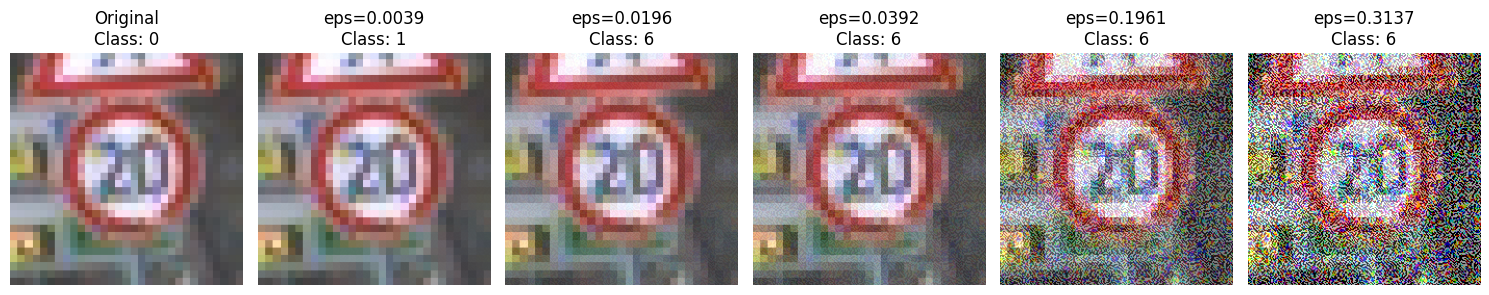

In [13]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
sample_index = 0  # Индекс изображения для демонстрации
original_image = x_test[sample_index]
original_label = np.argmax(y_test[sample_index])
# 3. Генерация атакованных изображений
attacked_images = []
predicted_classes = []

for eps in eps_values:
    # Создание FGSM атаки
    attack = FastGradientMethod(estimator=classifier, eps=eps)

    # Генерация атакованного изображения
    attacked_image = attack.generate(x=original_image.reshape(1, *original_image.shape))[0]
    attacked_images.append(attacked_image)

    # Предсказание класса
    prediction = classifier.predict(attacked_image.reshape(1, *attacked_image.shape))
    predicted_class = np.argmax(prediction)
    predicted_classes.append(predicted_class)

# 4. Визуализация
plt.figure(figsize=(15, 10))

# Отображение исходного изображения
plt.subplot(1, len(eps_values) + 1, 1)
plt.imshow(original_image)
plt.title(f"Original\nClass: {original_label}")
plt.axis("off")

# Отображение атакованных изображений
for i, eps in enumerate(eps_values):
    plt.subplot(1, len(eps_values) + 1, i + 2)
    plt.imshow(attacked_images[i])
    plt.title(f"eps={eps:.4f}\nClass: {predicted_classes[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

12. ## Выполнение атак PGD с различными значениями eps


1. **Параметры PGD атаки**:
   - В данном эксперименте используется несколько значений `eps = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]` для атаки PGD.
   - Каждая атака выполняется с шагом изменения за итерацию `eps_step = 2 / 255` и максимальным количеством итераций `max_iter = 40`.

2. **Атака PGD для различных eps**:
   - Для каждого значения `eps` в `eps_values` создается атака PGD с параметрами, которые включают норму, шаг и количество итераций.
   - На каждом шаге генерируются атакованные данные и оценивается точность модели на этих данных.
   - Точность модели определяется путем вычисления доли правильных предсказаний на атакованных данных.
   
3. **Результаты атаки**:
   - Результаты точности для каждого значения `eps` собираются и выводятся на экран.
   - Чем выше значение `eps`, тем сильнее атака, что может значительно повлиять на точность модели.

4. **Визуализация атак**:
   - Для выбранного изображения (в данном случае индекс `sample_index = 0`) отображаются как исходное изображение, так и несколько атакованных версий с разными значениями `eps`.
   - Для каждого атакованного изображения показывается соответствующая метка класса, которую предсказала модель на атакованном изображении.

Выполняется PGD атака с eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.003922): 2.00%
Выполняется PGD атака с eps=0.007843...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.007843): 0.00%
Выполняется PGD атака с eps=0.011765...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.011765): 0.00%
Выполняется PGD атака с eps=0.015686...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.015686): 0.00%
Выполняется PGD атака с eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.019608): 0.00%
Выполняется PGD атака с eps=0.031373...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.031373): 0.00%
Выполняется PGD атака с eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.039216): 0.00%
Выполняется PGD атака с eps=0.078431...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.078431): 0.00%
Выполняется PGD атака с eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.196078): 0.00%
Выполняется PGD атака с eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.313725): 0.00%


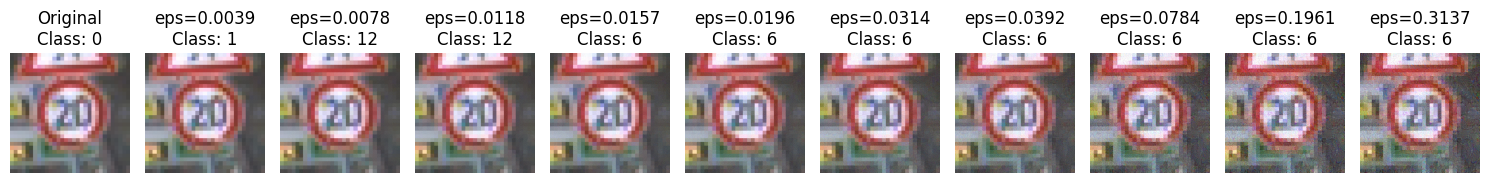


Результаты атак:
eps=0.003922, accuracy=2.00%
eps=0.007843, accuracy=0.00%
eps=0.011765, accuracy=0.00%
eps=0.015686, accuracy=0.00%
eps=0.019608, accuracy=0.00%
eps=0.031373, accuracy=0.00%
eps=0.039216, accuracy=0.00%
eps=0.078431, accuracy=0.00%
eps=0.196078, accuracy=0.00%
eps=0.313725, accuracy=0.00%


In [14]:
eps_values = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
eps_step = 2 / 255  # Шаг изменения за итерацию
max_iter = 40  # Количество итераций

# Выполнение PGD атак для каждого eps
results2 = []
attacked_images_per_eps2 = {}

for eps in eps_values:
    print(f"Выполняется PGD атака с eps={eps:.6f}...")

    # Создание PGD атаки
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=eps,
        eps_step=eps_step,
        max_iter=max_iter,
        targeted=False
    )

    # Генерация атакованных данных
    x_test_adv = attack.generate(x=x_test)
    attacked_images_per_eps2[eps] = x_test_adv  # Сохраняем атакованные изображения

    # Оценка модели на атакованных данных
    predictions = classifier.predict(x_test_adv, batch_size=50)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"Точность на атакованных данных (eps={eps:.6f}): {accuracy * 100:.2f}%")

    # Сохраняем результаты
    results2.append({'eps': eps, 'accuracy': accuracy})

# Визуализация для отдельных eps
sample_index = 0  # Индекс изображения для демонстрации
original_image = x_test[sample_index]

plt.figure(figsize=(15, 10))

# Исходное изображение
plt.subplot(1, len(eps_values) + 1, 1)
plt.imshow(original_image)
plt.title(f"Original\nClass: {np.argmax(y_test[sample_index])}")
plt.axis("off")

# Атакованные изображения
for i, eps in enumerate(eps_values):
    attacked_image = attacked_images_per_eps2[eps][sample_index]
    attacked_prediction = np.argmax(classifier.predict(attacked_image.reshape(1, *attacked_image.shape)))

    plt.subplot(1, len(eps_values) + 1, i + 2)
    plt.imshow(attacked_image)
    plt.title(f"eps={eps:.4f}\nClass: {attacked_prediction}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Вывод результатов
print("\nРезультаты атак:")
for result in results2:
    print(f"eps={result['eps']:.6f}, accuracy={result['accuracy'] * 100:.2f}%")

Результаты выполнения PGD-атаки показали, что точность модели значительно снижается даже при малых значениях параметра eps, который регулирует степень изменения пикселей в процессе атаки. Вот более детализированный анализ результатов:

Очень высокая уязвимость модели:

Даже при самых низких значениях eps = 0.003922, модель показывает точность 2%, что свидетельствует о ее уязвимости к атакам типа PGD. Это означает, что даже малые изменения в изображении могут существенно повлиять на способность модели классифицировать изображения правильно.
Резкое ухудшение точности с увеличением eps:

Как только eps увеличивается до значений около 0.007843, модель начинает ошибаться на всех примерах, с точностью, снижающейся до 0%. Это подчеркивает значительное снижение производительности на атакованных данных.
Механизм атаки:

Метод Projected Gradient Descent (PGD) предназначен для создания атак с максимальным угрожающим изменением (сохранением eps на каждом шаге), что объясняет столь серьезные последствия для работы модели при достаточно небольших значениях eps.

---

13. ## Выполнение атак FGSM и PGD с различными значениями `eps`

## 1. Задание значений `eps`

В данном эксперименте используется несколько значений для параметра `eps`, который контролирует степень искажения изображения при атаке. Перечень значений:

- `eps = [1/255, 5/255, 10/255, 50/255, 80/255]`

## 2. Словарь для хранения результатов

Для упрощения работы, результаты точности модели для атак FGSM и PGD будут храниться в словаре:

- `accuracy_results = {"FGSM": [], "PGD": []}`

Этот словарь будет содержать список точностей для каждой из атак при различных значениях `eps`.

## 3. Функция для выполнения атаки и оценки точности

Для каждого значения `eps` будут выполняться следующие шаги:

1. Настройка параметра `eps` для атаки.
2. Генерация атакованных изображений.
3. Оценка точности модели на этих изображениях.

Точность модели оценивается как доля правильных предсказаний на атакованных изображениях.

## 4. Оценка для атак FGSM и PGD

В этом эксперименте будет создано два объекта атаки: один для **Fast Gradient Sign Method (FGSM)** и другой для **Projected Gradient Descent (PGD)**. Параметр `eps` будет изменяться для каждого значения из списка `eps_values`.

1. Для FGSM создается атака, где `eps` обновляется на каждом шаге для получения атакованных данных.
2. Для PGD также используется `eps`, с шагом изменения и максимальным количеством итераций, которые также будут обновляться.

## 5. Оценка точности модели для FGSM

Модель будет оцениваться для каждого значения `eps` с использованием FGSM атаки, и результат будет храниться в словаре `accuracy_results`.

## 6. Оценка точности модели для PGD

Так же как и для FGSM, будет проведена оценка для атаки PGD, и результаты будут сохраняться в том же словаре для дальнейшего анализа.

## 7. Построение графика точности в зависимости от `eps`


Evaluating FGSM with eps=0.003922...
FGSM Accuracy at eps=0.003922: 16.00%
Evaluating FGSM with eps=0.019608...
FGSM Accuracy at eps=0.019608: 14.00%
Evaluating FGSM with eps=0.039216...
FGSM Accuracy at eps=0.039216: 2.00%
Evaluating FGSM with eps=0.196078...
FGSM Accuracy at eps=0.196078: 0.00%
Evaluating FGSM with eps=0.313725...
FGSM Accuracy at eps=0.313725: 0.00%
Evaluating PGD with eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.003922: 2.00%
Evaluating PGD with eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.019608: 0.00%
Evaluating PGD with eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.039216: 0.00%
Evaluating PGD with eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.196078: 0.00%
Evaluating PGD with eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.313725: 0.00%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120598 (\N{MATHEMATICAL ITALIC EPSILON SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


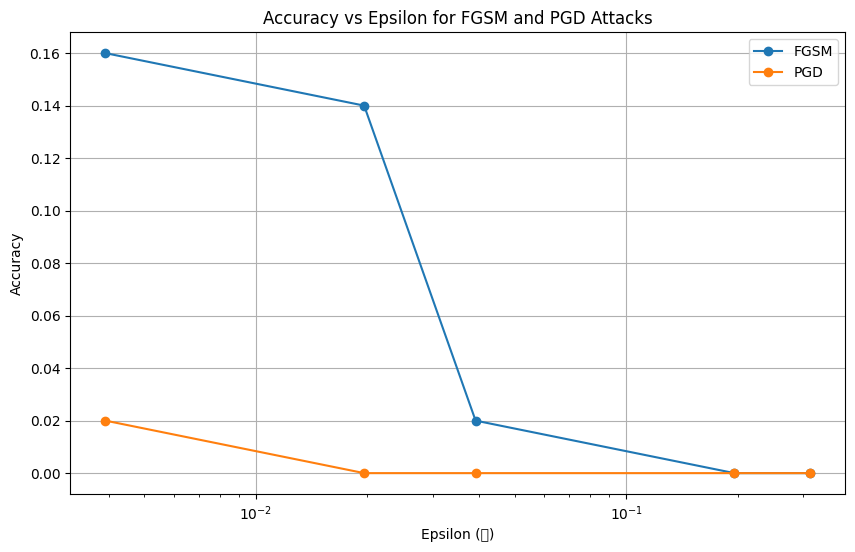

In [15]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
accuracy_results = {"FGSM": [], "PGD": []}

# Функция для выполнения атаки и оценки точности
def evaluate_attack(attack_name, attack_object, x_test, y_test):
    accuracies = []
    for eps in eps_values:
        print(f"Evaluating {attack_name} with eps={eps:.6f}...")

        # Обновляем параметр eps для атаки
        attack_object.set_params(eps=eps)

        # Генерация атакованных данных
        x_test_adv = attack_object.generate(x=x_test)

        # Оценка точности
        predictions = classifier.predict(x_test_adv, batch_size=16)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print(f"{attack_name} Accuracy at eps={eps:.6f}: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)
    return accuracies
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.0)  # eps будет изменяться в цикле
pgd_attack = ProjectedGradientDescent(
    estimator=classifier,
    norm=np.inf,
    eps=0.0,  # eps будет изменяться в цикле
    eps_step=2/255,
    max_iter=40,
    targeted=False
)
# Оценка модели для FGSM
accuracy_results["FGSM"] = evaluate_attack("FGSM", fgsm_attack, x_test, y_test)

# Оценка модели для PGD
accuracy_results["PGD"] = evaluate_attack("PGD", pgd_attack, x_test, y_test)

# Построение графика
plt.figure(figsize=(10, 6))

plt.plot(eps_values, accuracy_results["FGSM"], marker='o', label='FGSM')
plt.plot(eps_values, accuracy_results["PGD"], marker='o', label='PGD')

# Настройки графика
plt.title('Accuracy vs Epsilon for FGSM and PGD Attacks')
plt.xlabel('Epsilon (𝜖)')
plt.ylabel('Accuracy')
plt.xscale('log')  # Логарифмическая шкала для eps
plt.grid(True)
plt.legend()

# Отображение графика
plt.show()

14. ## Оценка точности модели VGG16 на атаках FGSM и PGD

### 1. Подготовка тестовых данных:
- Загружаются изображения для тестирования модели с использованием `ImageDataGenerator` для нормализации изображений.
- Из директории `test` (папка для тестовых данных) формируется генератор для подачи батчей изображений в модель.
- Размер изображений изменяется на `(224, 224)` — это подходящий размер для сети VGG16.

### 2. Загрузка модели VGG16:
- Модель VGG16 загружается из файла `vgg16.h5`, который должен быть предварительно обучен.
- С помощью функции `predict_fn_vgg16` реализуется прогноз на основе загруженной модели.

### 3. Создание атак:
- В коде созданы две атаки на основе классов `FastGradientMethod` (FGSM) и `ProjectedGradientDescent` (PGD):
    - Для FGSM и PGD используется параметр `eps`, который изменяется в заданных пределах, чтобы протестировать влияние разных уровней атак.
    - Для атак PGD задается шаг атаки (`eps_step=2/255`), максимальное количество итераций (40), а также нормировка по бесконечной норме (`np.inf`).

### 4. Функция для выполнения атак:
- Функция `evaluate_attack`:
    - Для каждого значения `eps` из заранее заданных (1/255, 5/255, 10/255, 50/255, 80/255) проводится атака.
    - Для каждой атаки генерируются атакованные изображения (`x_test_adv`).
    - Точность модели вычисляется как отношение правильно предсказанных меток к общему числу примеров.

### 5. Оценка для FGSM и PGD:
- Для каждой из атак (FGSM и PGD) моделируется предсказание точности, и результаты сохраняются в словарь `accuracy_results_vgg16` с ключами `"FGSM"` и `"PGD"`.
   
### 6. График точности:

Found 7842 images belonging to 43 classes.
Evaluating FGSM with eps=0.003922...
FGSM Accuracy at eps=0.003922: 45.00%
Evaluating FGSM with eps=0.019608...
FGSM Accuracy at eps=0.019608: 47.50%
Evaluating FGSM with eps=0.039216...
FGSM Accuracy at eps=0.039216: 32.50%
Evaluating FGSM with eps=0.196078...
FGSM Accuracy at eps=0.196078: 0.00%
Evaluating FGSM with eps=0.313725...
FGSM Accuracy at eps=0.313725: 0.00%
Evaluating PGD with eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.003922: 27.50%
Evaluating PGD with eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.019608: 0.00%
Evaluating PGD with eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.039216: 0.00%
Evaluating PGD with eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.196078: 0.00%
Evaluating PGD with eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.313725: 0.00%


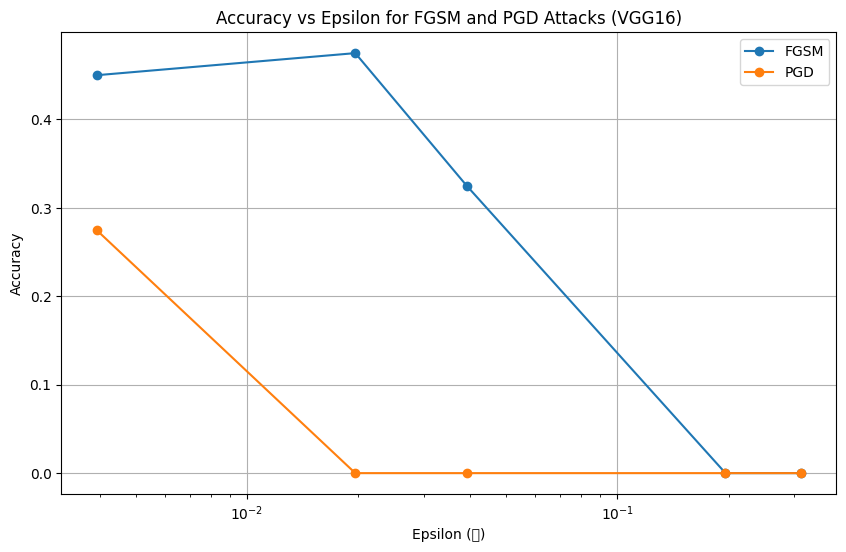

In [17]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
accuracy_results_vgg16 = {"FGSM": [], "PGD": []}

# Функция для выполнения атаки и оценки точности
def evaluate_attack(attack_name, attack_object, x_test, y_test):
    accuracies = []
    for eps in eps_values:
        print(f"Evaluating {attack_name} with eps={eps:.6f}...")

        # Обновляем параметр eps для атаки
        attack_object.set_params(eps=eps)

        # Генерация атакованных данных
        x_test_adv = attack_object.generate(x=x_test)

        # Оценка точности
        predictions = classifier_vgg16.predict(x_test_adv, batch_size=16)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print(f"{attack_name} Accuracy at eps={eps:.6f}: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)
    return accuracies
model_vgg16 = tf.keras.models.load_model('/content/vgg16.h5')

def predict_fn_vgg16(x, training=False):
    return model_vgg16(x, training=training)

loss_object_vgg16 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
classifier_vgg16 = TensorFlowV2Classifier(
    model=predict_fn_vgg16,
    nb_classes=43,
    input_shape=(224, 224, 3),
    clip_values=(0, 1),
    loss_object=loss_object_vgg16
)

# Подготовка тестовых данных
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

test_dir = os.path.join(output_dir, 'test')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=40,
    class_mode='categorical',
    shuffle=False
)

x_test, y_test = next(test_generator)

# Создание атак
fgsm_attack_vgg16 = FastGradientMethod(estimator=classifier_vgg16, eps=0.0)  # eps будет изменяться в цикле
pgd_attack_vgg16 = ProjectedGradientDescent(
    estimator=classifier_vgg16,
    norm=np.inf,
    eps=0.0,  # eps будет изменяться в цикле
    eps_step=2/255,
    max_iter=40,
    targeted=False
)

# Оценка модели VGG16 для FGSM
accuracy_results_vgg16["FGSM"] = evaluate_attack("FGSM", fgsm_attack_vgg16, x_test, y_test)

# Оценка модели VGG16 для PGD
accuracy_results_vgg16["PGD"] = evaluate_attack("PGD", pgd_attack_vgg16, x_test, y_test)

# Построение графика
plt.figure(figsize=(10, 6))

plt.plot(eps_values, accuracy_results_vgg16["FGSM"], marker='o', label='FGSM')
plt.plot(eps_values, accuracy_results_vgg16["PGD"], marker='o', label='PGD')

# Настройки графика
plt.title('Accuracy vs Epsilon for FGSM and PGD Attacks (VGG16)')
plt.xlabel('Epsilon (𝜖)')
plt.ylabel('Accuracy')
plt.xscale('log')  # Логарифмическая шкала для eps
plt.grid(True)
plt.legend()

# Отображение графика
plt.show()

15. ## Таблица с результатами точности для моделей VGG16 и ResNet50

In [18]:
import pandas as pd

# 1. Данные точности (примерные результаты или реальные значения)
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]

# Результаты точности для FGSM и PGD для обеих моделей
accuracy_vgg16_fgsm = accuracy_results_vgg16["FGSM"]
accuracy_vgg16_pgd = accuracy_results_vgg16["PGD"]

accuracy_resnet50_fgsm = accuracy_results["FGSM"]
accuracy_resnet50_pgd = accuracy_results["PGD"]

# 2. Создание DataFrame
data = {
    "Epsilon (𝜖)": eps_values,
    "VGG16 FGSM": accuracy_vgg16_fgsm,
    "VGG16 PGD": accuracy_vgg16_pgd,
    "ResNet50 FGSM": accuracy_resnet50_fgsm,
    "ResNet50 PGD": accuracy_resnet50_pgd
}

df = pd.DataFrame(data)

# 3. Вывод таблицы
print("Таблица точности:")
print(df)


Таблица точности:
   Epsilon (𝜖)  VGG16 FGSM  VGG16 PGD  ResNet50 FGSM  ResNet50 PGD
0     0.003922       0.450      0.275           0.16          0.02
1     0.019608       0.475      0.000           0.14          0.00
2     0.039216       0.325      0.000           0.02          0.00
3     0.196078       0.000      0.000           0.00          0.00
4     0.313725       0.000      0.000           0.00          0.00
